Analysis of brain weight given the variables of gender, head size and age-range

In [2]:

# import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score
import shap

# Set random seed for reproducibility
np.random.seed(42)

# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Load the dataset into pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/brain_data.csv', sep=',', na_values='.')

# Display first few rows to understand the dataset structure
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Gender,Age Range,Head Size(cm^3),Brain Weight(grams)
0,1,1,4512,1530
1,1,1,3738,1297
2,1,1,4261,1335
3,1,1,3777,1282
4,1,1,4177,1590


In [3]:
# Checking for null values
df.isnull().sum()

,0
Gender,0
Age Range,0
Head Size(cm^3),0
Brain Weight(grams),0


# Performing EDA
- Checking for null values and dataset summary
- Basic statistics of the dataset

In [4]:
# Checking for null values and dataset summary
df.info()

# Basic statistics of the dataset
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Gender               237 non-null    int64
 1   Age Range            237 non-null    int64
 2   Head Size(cm^3)      237 non-null    int64
 3   Brain Weight(grams)  237 non-null    int64
dtypes: int64(4)
memory usage: 7.5 KB


,Gender,Age Range,Head Size(cm^3),Brain Weight(grams)
count,237.000000,237.000000,237.000000,237.000000
mean,1.434599,1.535865,3633.991561,1282.873418
std,0.496753,0.499768,365.261422,120.340446
min,1.000000,1.000000,2720.000000,955.000000
25%,1.000000,1.000000,3389.000000,1207.000000
50%,1.000000,2.000000,3614.000000,1280.000000
75%,2.000000,2.000000,3876.000000,1350.000000
max,2.000000,2.000000,4747.000000,1635.000000


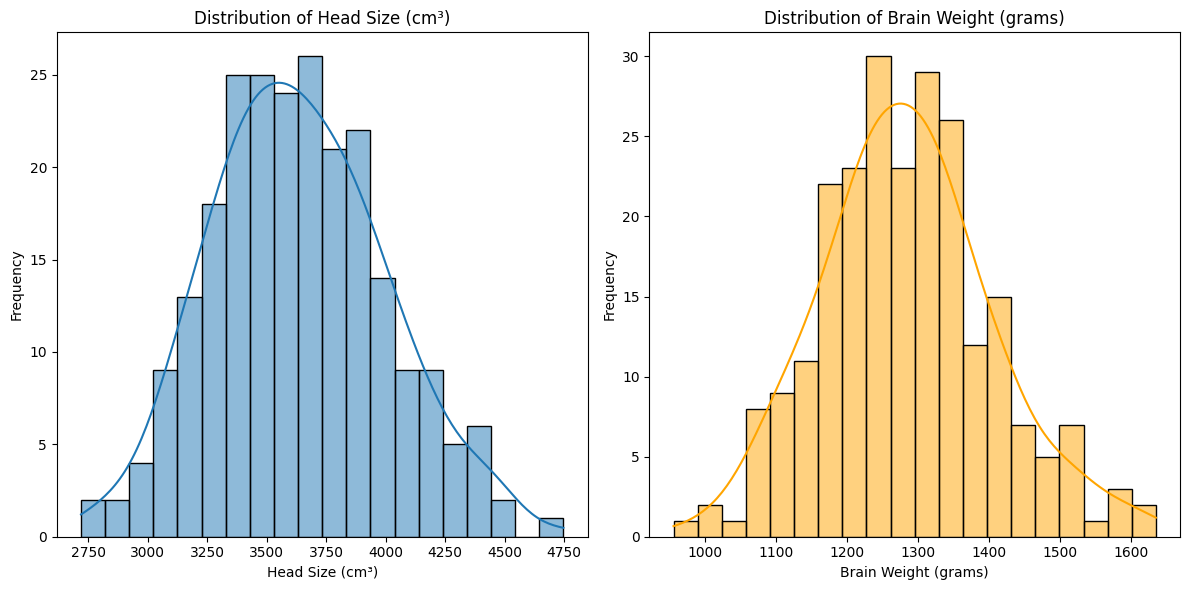

In [5]:
# Visualizing the distribution of head size and brain weight
plt.figure(figsize=(12, 6))

# Head size distribution
plt.subplot(1, 2, 1)
sns.histplot(df['Head Size(cm^3)'], kde=True, bins=20)
plt.title('Distribution of Head Size (cm³)')
plt.xlabel('Head Size (cm³)')
plt.ylabel('Frequency')

# Brain weight distribution
plt.subplot(1, 2, 2)
sns.histplot(df['Brain Weight(grams)'], kde=True, bins=20, color='orange')
plt.title('Distribution of Brain Weight (grams)')
plt.xlabel('Brain Weight (grams)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

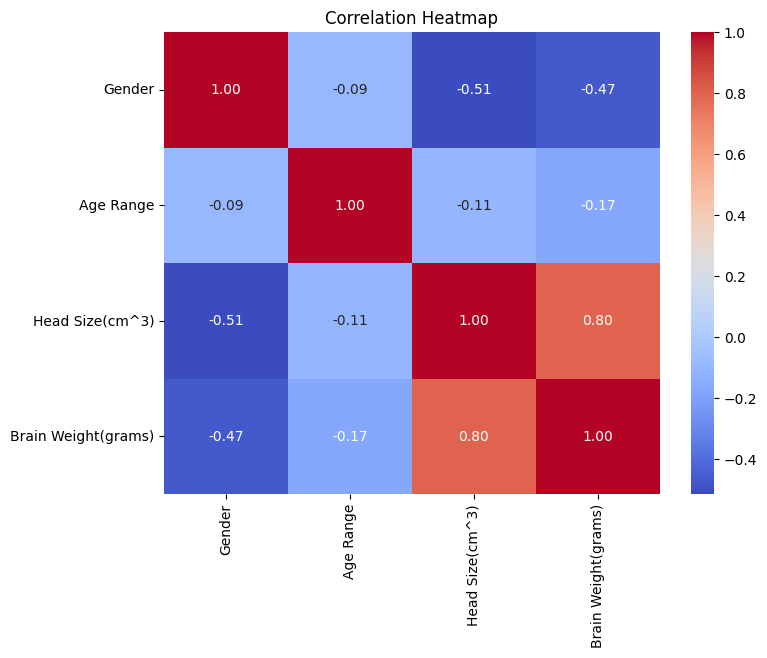

In [ ]:
# Correlation heatmap to analyze feature relationships
plt.figure(figsize=(8, 6))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

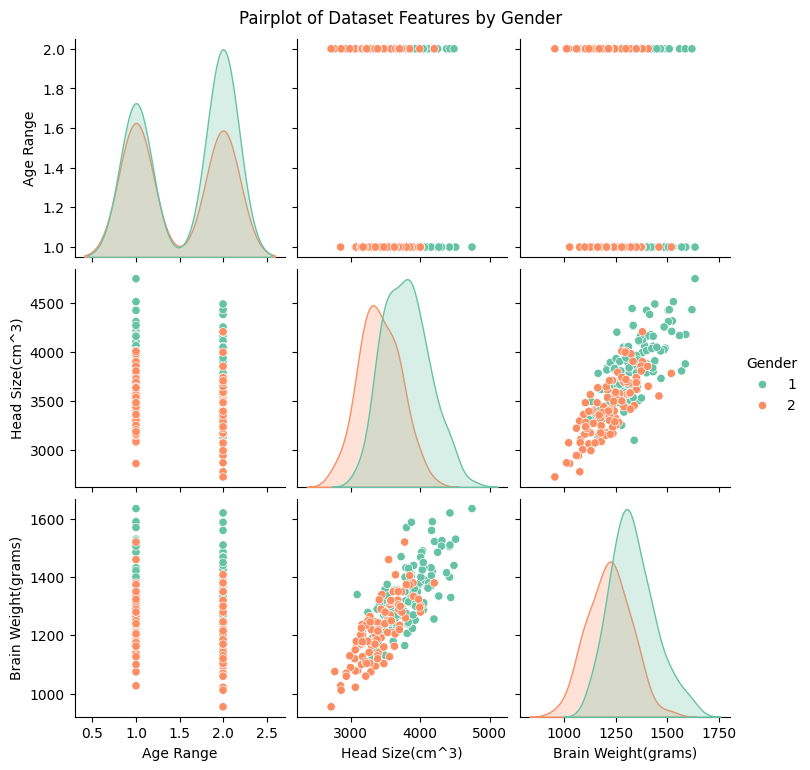

In [6]:
# Pairplot to visualize relationships between features
sns.pairplot(df, diag_kind='kde', hue='Gender', palette='Set2')
plt.suptitle("Pairplot of Dataset Features by Gender", y=1.02)
plt.show()

In [7]:
# Remove outliers using Z-Score
from scipy.stats import zscore
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
data = df[(z_scores < 3).all(axis=1)]
print("\nData Shape After Removing Outliers:", data.shape)


Data Shape After Removing Outliers: (236, 4)


In [12]:
# Splitting features and target
X = data.drop(columns=['Brain Weight(grams)'])
y = data['Brain Weight(grams)']

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\nTrain Shape:", X_train.shape)
print("Validation Shape:", X_val.shape)
print("Test Shape:", X_test.shape)



Train Shape: (165, 3)
Validation Shape: (35, 3)
Test Shape: (36, 3)


In [13]:
## Step 4: Model Implementation
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVM': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Neural Network': MLPRegressor(random_state=42, max_iter=500)
}

# Training and evaluating models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

Linear Regression - MSE: 4369.35, R2: 0.74
Decision Tree - MSE: 10504.47, R2: 0.37
Random Forest - MSE: 4941.44, R2: 0.70
SVM - MSE: 16095.38, R2: 0.03
Gradient Boosting - MSE: 5810.04, R2: 0.65
Neural Network - MSE: 22883.42, R2: -0.38


In [14]:
## Step 5: Hyperparameter Tuning for Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("\nBest Random Forest Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
best_rf_predictions = best_rf.predict(X_test)
print("\nTuned Random Forest - R2:", r2_score(y_test, best_rf_predictions))

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

Tuned Random Forest - R2: 0.7690111595987975


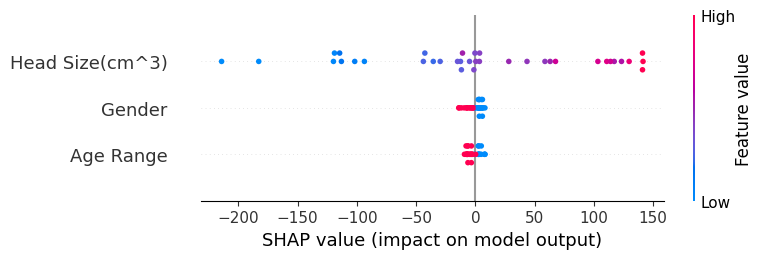

In [15]:
## Step 6: Explainable AI Using SHAP
explainer = shap.Explainer(best_rf, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

In [16]:
## Step 7: Final Evaluation Metrics
final_predictions = best_rf.predict(X_test)
precision = precision_score(y_test, np.round(final_predictions), average='weighted', zero_division=1)
recall = recall_score(y_test, np.round(final_predictions), average='weighted', zero_division=1)
f1 = f1_score(y_test, np.round(final_predictions), average='weighted', zero_division=1)

print("\nFinal Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)



Final Metrics:
Precision: 0.9166666666666666
Recall: 0.027777777777777776
F1-Score: 0.037037037037037035


In [17]:
# Displaying all results
for name, metrics in results.items():
    print(f"\n{name}: MSE={metrics['MSE']:.2f}, R2={metrics['R2']:.2f}")



Linear Regression: MSE=4369.35, R2=0.74

Decision Tree: MSE=10504.47, R2=0.37

Random Forest: MSE=4941.44, R2=0.70

SVM: MSE=16095.38, R2=0.03

Gradient Boosting: MSE=5810.04, R2=0.65

Neural Network: MSE=22883.42, R2=-0.38
